# Playground

This section is for playing orund with the final result.
First you have to execute the setup section. Afterwards you can do one of the following:
- Classification on a static Image [here](#image)
- Realtime classificaton on a webcam video stream [here](#video)

## Setup 

In [9]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import torchvision
import time
import os
import copy
import cv2
from IPython.display import clear_output
from PIL import Image
from io import BytesIO
import IPython.display
%matplotlib inline

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# load classification model
NUM_CLASSES = 5
MODEL_DIR = "models/iteration_five/"
MODEL_NAME = "CHORDS_MODEL_BEST_LOSS.pth"

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
if device.type == 'cpu':
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR, MODEL_NAME), map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR, MODEL_NAME), map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

class_names_classification = ['a_chord', 'c_chord', 'd_chord', 'e_chord', 'g_chord']





In [12]:
from torch.autograd import Variable
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd_predictor
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd

# create object detection model

model_path = "models/iteration_four/GUITAR_HANDS_IMPROVED.pth"

class_names_detection = ["BACKGROUND", "chord_hand", "strumming_hand"]

detection_model = create_mobilenetv1_ssd(len(class_names_detection), is_test=True)

detection_model.load(model_path)

detection_model.eval()

predictor = create_mobilenetv1_ssd_predictor(detection_model, candidate_size=200)

  

In [13]:

from utils.crop_image import crop_image
from utils.object_detection_utils import draw_boxes_on_image

In [14]:
import torch.nn.functional as nnf

imsize = 224
loader = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_chord(image, classifier):
    classifier.eval()
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    inputs = image.to(device)

    with torch.no_grad():

        outputs = classifier(inputs)
        prob = nnf.softmax(outputs, dim=1)
        top_p, top_class = prob.topk(1, dim = 1)
        return top_p, top_class


def detect_hand_and_predict_chord(image, predictor, classifier, requested_label, threshold = 0.6, classification_threshold = 0.6):
    boxes, labels, probs = predictor.predict(image, 5, threshold)
    labels_probs = [f"{class_names_detection[labels[i]]}: {probs[i]:.2f}" for i in range(boxes.size(0))]
    for i in range(boxes.size(0)):
        box = boxes[i, :].int().numpy()
        if class_names_detection[labels[i]] == requested_label:
            cropped_image = crop_image(image, box)
            prob, chord_index = predict_chord(cropped_image, classifier)
            if prob[0][0] > 0.3:
                label = f"{class_names_classification[chord_index]}: {prob[0][0]:.2f}"
                image = Image.fromarray(image)
                image.paste(Image.open("static/notebook_images/" + class_names_classification[chord_index] + ".png").resize((200, 300)))
                image = np.array(image)
            else:
                label = "Unknown chord"
            cv2.putText(image, label ,
                          (box[0] , box[3] - 40),
                          cv2.FONT_HERSHEY_SIMPLEX,
                          1, 
                          (255, 0, 255),
                          2)  
    return draw_boxes_on_image(image, labels_probs, boxes=boxes.int())

## <a name="image"></a> Static on Image
Use this to do some guitar hands predictions and chord classifications based on static images

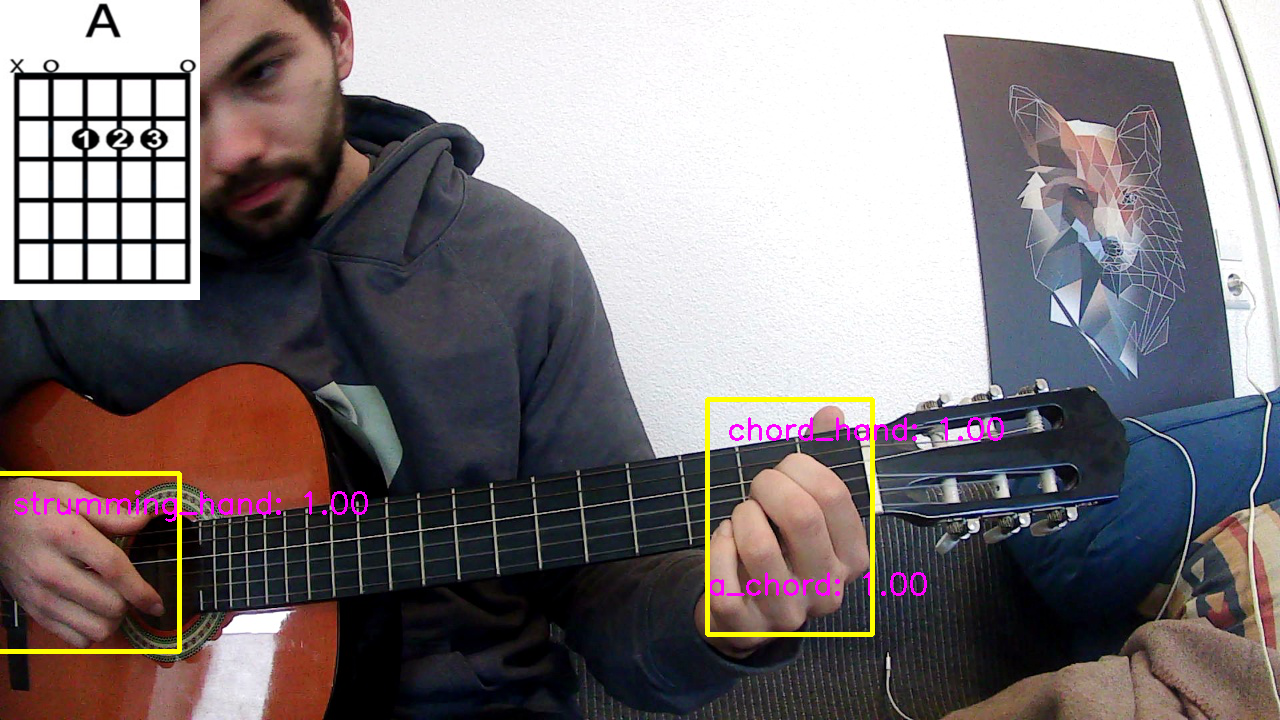

In [21]:
# some image from the train set
IMAGE_PATH = "data/chords/dataset_iteration_five/a_chord/1-a_chord-5.jpg"

np_image = np.array(Image.open(IMAGE_PATH))
detected_image = detect_hand_and_predict_chord(np_image, predictor, model, "chord_hand")
Image.fromarray(detected_image)

## <a name="video"></a> Realtime on webcam video
Here you can do live guitar hand detection and chord classification on the webcam.

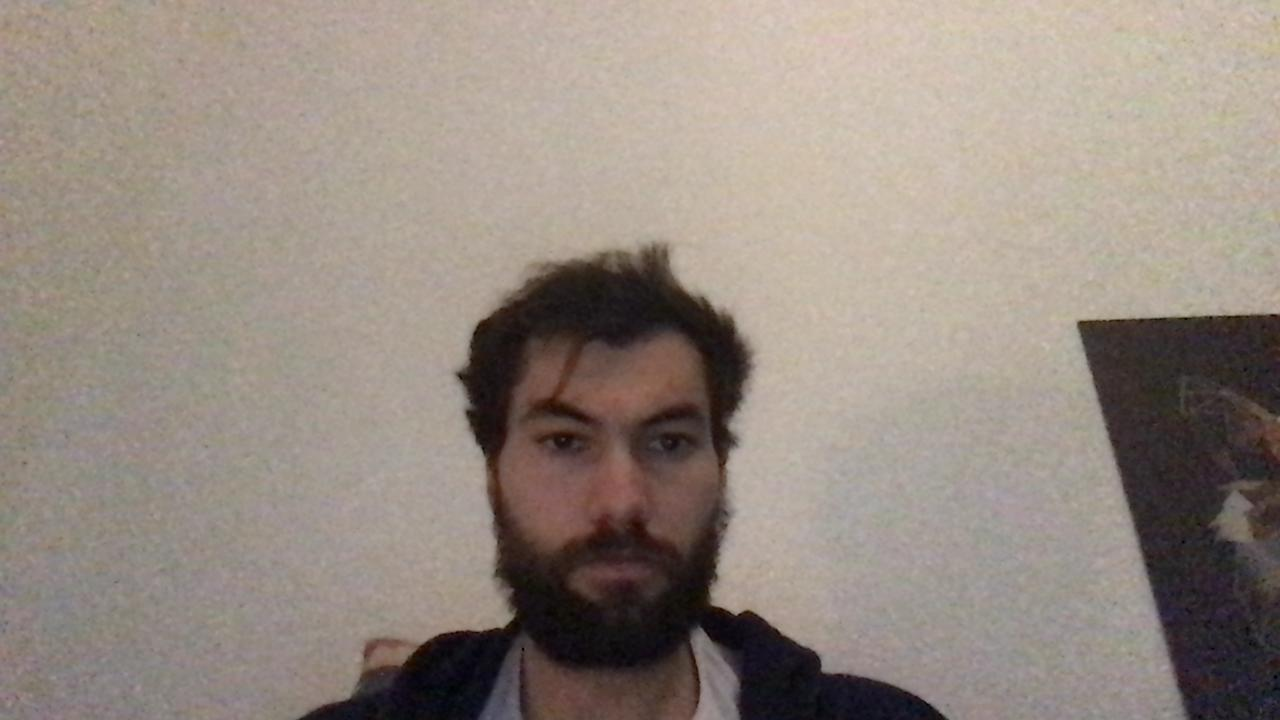

Stream stopped


In [17]:
# define the id of the webcam. Probably 0 or 1
CAM_ID = 0

DETECTION_THRESHOLD = 0.8
CLASSIFICATION_THRESHOLD = 0.6

def showarray(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

cam = cv2.VideoCapture(CAM_ID)
try:
    while(True):
        t1 = time.time()
        
        # Capture frame-by-frame
        frame = ret, frame = cam.read()

        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = detect_hand_and_predict_chord(frame, predictor, model, "chord_hand", 
                                              threshold=DETECTION_THRESHOLD,
                                             classification_threshold=CLASSIFICATION_THRESHOLD)
        clear_output(wait=True)
        showarray(frame)
        
        time.sleep(0.2)

        #print("%f FPS" % (1/(t2-t1)))
        # Display the frame until new frame is available

except KeyboardInterrupt:
    cam.release()
    print("Stream stopped")